In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
from sklearn.metrics import accuracy_score,recall_score, precision_score
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.manifold import TSNE
import time
import matplotlib.patheffects as PathEffects

In [37]:
class preprocess:
    
    def train_test_split(self,X,Y):
        
        self.xtrain,self.xtest,self.ytrain,self.ytest=train_test_split(X,Y,test_size=0.2,random_state=0,stratify=Y)
        return self.xtrain,self.xtest,self.ytrain,self.ytest
    
    def extract_class(self,X,Y,class_):
        
        indx1=np.where(Y == class_)
        min_class_x=X.iloc[indx1[0],:] 
        return min_class_x
    
    def pages_per_sec(self,dataset,x,y):
        
        column_index1=dataset.columns.get_loc(x)
        column_index2=dataset.columns.get_loc(y)
        row_index=np.where(dataset[x]>0)
        for i in row_index:
            dataset.iloc[i,column_index1]=dataset.iloc[i,column_index2]/dataset.iloc[i,column_index1]
        return dataset.drop(labels=y,axis=1)
    
    def rare_categories(self,X,categories):
        
        for i in categories:
            if (i=='Month') or (i=='VisitorType'):
                frequency=X[i].value_counts(normalize=True)
                mapping=X[i].map(frequency)
                X[i]=X[i].mask(mapping<0.09,'Other')
            else:
                frequency=X[i].value_counts(normalize=True)
                mapping=X[i].map(frequency)
                X[i]=X[i].mask(mapping<0.09,max(X[i])+1)
                
        return X
    
    def add_prefix(self,X,categories):
        
        for i in categories:
            X[i]= i + X[i].astype(str)
            
        return X
    
    def log_normalize(self,X,num_columns):
        
        for i in num_columns:
            X[i]=np.log(X[i]+1)
        
        return X
    
    
class smote:
    
    def __init__(self,x,y,min_class,num_columns,cat_columns,cat_start_index):
        
        self.x=x
        self.y=y
        self.min_class=min_class
        self.num_columns=num_columns
        self.cat_columns=cat_columns
        self.cat_start_index=cat_start_index
        
    def extract_class(self,X,Y,class_):
        
        indx1=np.where(Y == class_)
        min_class_x=X.iloc[indx1[0],:] 
        return min_class_x
    
    def one_hot_encoding(self,x,categories):
        
        x_converted=pd.get_dummies(x,columns=categories,prefix='',prefix_sep='')
        
        return x_converted
    
    
    def median_std(self,x):
        
        std=np.std(x,axis=0).values
        std.sort()
        median=np.median(std)
        
        return median
    
    def neighbours(self,x_num,x_cat):
        
        median=self.median_std(x_num)
        euclidean_distance=[]
        for i in tqdm(range(x_num.shape[0])):
            distance=[]
            for j in range(x_num.shape[0]):
                count=0
                for n in (range(x_cat.shape[1])):
                    if x_cat.iloc[i,n]!=x_cat.iloc[j,n]:
                        count=count+1
                
                distance.append(np.sqrt(sum((x_num.iloc[j]-x_num.iloc[i])**2))+count*median**2)        
            euclidean_distance.append(distance)
        euclidean_distance=np.asarray(euclidean_distance)
        index_asc=[]
        for i in range(len(euclidean_distance)):
            index_asc.append(np.argsort(euclidean_distance[i]))
        index_asc=np.asarray(index_asc)
        neighbour_points=index_asc[:,1:4]
        
        return neighbour_points,euclidean_distance
    
    def points(self,neighbour_points,x,column_names):    
        
        #a=randint(0,x.shape[1]-1)
        m=[]
        for a in tqdm(range(x.shape[0])):
            b=neighbour_points[a,:]
            gap=random.uniform(0,1)
            for n in (b):
                diff=[]
                for i in range(x.shape[1]):
                    diff.append(gap*(x.iloc[a][i])+(1-gap)*(x.iloc[n][i]))
                m.append(diff)
        #m=np.asarray(m,dtype=np.float)
        m=pd.DataFrame(m)
        m.columns=column_names
        m.iloc[:,self.cat_start_index:]=np.around(m.iloc[:,self.cat_start_index:])
        #x=x.append(m,ignore_index=True)
        cat_col=column_names[self.cat_start_index:]
        for i in cat_col:
            m[i]=m[i].astype(int)
        
        return m
    
    
    def smote_nc(self):
            
            x_ohc=self.one_hot_encoding(self.x,self.cat_columns)
            x_minclass=self.extract_class(x_ohc,self.y,self.min_class)
            
            column_names=list(x_minclass.columns)
            x_num=x_minclass.iloc[:,:self.cat_start_index]
            x_cat=x_minclass.iloc[:,self.cat_start_index:]
            neighbour_points,euclidean_distance=self.neighbours(x_num,x_cat)
            new_points=self.points(neighbour_points,x_minclass,column_names)
            
            df=pd.DataFrame(new_points.iloc[:,:self.cat_start_index],columns=self.num_columns)
            
            #converting points to original form
            
            month=new_points.iloc[:,7:12]
            df['Month']=month.dot(month.columns)
            
            operatingsystems=new_points.iloc[:,12:16]
            df['OperatingSystems']=operatingsystems.dot(operatingsystems.columns)
            
            
            browser=new_points.iloc[:,16:19]
            df['Browser']=browser.dot(browser.columns)
            
            
            region=new_points.iloc[:,19:24]
            df['Region']=region.dot(region.columns)
            
            
            traffictype=new_points.iloc[:,24:28]
            df['TrafficType']=traffictype.dot(traffictype.columns)
            
            
            visitortype=new_points.iloc[:,28:31]
            df['VisitorType']=visitortype.dot(visitortype.columns)
            
            weekend=new_points.iloc[:,31:]
            df['Weekend']=weekend.dot(weekend.columns)
            
            
            return df

class Radial_basis_Oversampling:
    
    def __init__(self,X,Y,minority_class_label,majority_class_label,lamda,count,step_size,cat_start_index,categorical_columns):
        
        self.X=X
        self.Y=Y
        self.min_class_label=minority_class_label
        self.maj_class_label=majority_class_label
        self.lamda=lamda
        self.count=count
        self.step_size=step_size
        self.cat_start_index=cat_start_index
        self.categorical_columns=categorical_columns
        
    def label_encoding(self):
        
        self.encoder=[]
        for i,j in zip(self.categorical_columns,self.categorical_columns):
            j=LabelEncoder()
            self.X[i]=j.fit_transform(self.X[i])
            self.encoder.append(j)       
    
    def inverse_label_encoding(self,x):
        
        for i,j in zip(self.encoder,self.categorical_columns):
            x[j]=i.inverse_transform(x[j].astype(int))
            
        return x
    
    def extract_class(self,X,Y):
        
        indx1=np.where(Y == self.min_class_label)
        self.min_class_x=X.iloc[indx1[0],:] 
        indx2=np.where(Y==self.maj_class_label)
        self.max_class_x=X.iloc[indx2[0],:]
    
    def score(self,point):
        
        score1=[]
        for i in (self.max_class_x.values):
            score1.append(np.exp(-(np.abs(i-point)/self.lamda)**2))
        score1_=np.sum(score1)
        
        score2=[]
        for i in self.min_class_x.values:
            score2.append(np.exp(-(np.abs(i-point)/self.lamda)**2))
        score2_=np.sum(score2)
        
        score=score1_-score2_
        
        return score
    
    def points(self):
        
        count=0
        self.label_encoding()
        self.extract_class(self.X,self.Y)
        
        minority_score=[]
        for i in tqdm(self.min_class_x.values):
            score=self.score(i)
            minority_score.append(score)
        
        new_points=[]
        
        while len(new_points)<self.count:
            
            indx=np.random.choice(len(self.min_class_x.index))
            minority_point=self.min_class_x.iloc[indx].values
            score=self.score(minority_point)
            
            for i in range(5):
                
                direction=np.zeros(len(minority_point))    
                side=np.random.choice([1,-1])
                x=np.random.choice(range(len(minority_point)))
                
                if (x>self.cat_start_index) or (x==self.cat_start_index):
                    minority_point[x] = np.random.choice(self.X.iloc[:,x].unique()) 
                    new_point=minority_point
                
                else:
                    if minority_point[x]<self.step_size:
                        direction[x]=self.step_size
                        new_point=minority_point+direction
                    else:
                        direction[x] = side*self.step_size
                        new_point=minority_point+direction
                
                new_score=self.score(new_point)
                
                if abs(new_score)<abs(score):
                    #print(count)
                    new_points.append(new_point)
                    score=new_score
                    count+=1
                
        new_points=pd.DataFrame(new_points,columns=self.X.columns)
        new_points=self.inverse_label_encoding(new_points)
        
        return new_points

    
class mRMR:
    
    def __init__(self,X,Y,num_of_features,numerical_columns):
        
        self.X=X
        self.Y=Y
        self.num_of_features=num_of_features
        self.numerical_columns=numerical_columns
    
    def binning(self,X,numerical_columns):
    
        for i in self.numerical_columns:

            mu=np.mean(X.loc[:,i])
            std=np.std(X.loc[:,i])
            bin_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8]
            cut_bins = [(mu-10*std),(mu-2*std),(mu-1.5*std),(mu-std),(mu-0.5*std),(mu+0.5*std),(mu+std),(mu+1.5*std),(mu+2*std), (mu+10*std)]
            X.loc[:,i] = pd.cut(X.loc[:,i],bins=cut_bins,labels=bin_labels)

        return X
    
    def mutual_information(self,X,Y):
    
        mi=0
        for i in set(X):
            for j in set(Y):
                ni=(X==i)
                pi=np.mean(ni)
                nj=(Y==j)
                pj=np.mean(nj)
                nij=np.logical_and(ni,nj)
                pxy=np.mean(nij)
                if pxy!=0:
                    mi+=pxy*np.log(pxy/(pi*pj))
        return mi
    
    def max_mi(self,X,Y): 

        MI=[]
        columns=X.columns
        for i in columns:
            col=X.loc[:,i]
            MI.append(self.mutual_information(col,Y))
        a=np.argsort(MI)[::-1][:1]
        column_name=columns[a[0]]

        return column_name

    def score(self,old_set,new_column,target):

        mi=0
        col=old_set.columns
        for i in col:
            mi+=self.mutual_information(old_set.loc[:,i],new_column)

        R=mi/len(col)

        I=self.mutual_information(new_column,target)

        score=I/R

        return score

    def select(self):

        self.X=self.binning(self.X,self.numerical_columns)
        selected_columns=[]
        
        first_column=self.max_mi(self.X,self.Y)
        selected_columns.append(first_column)
        new_set=self.X.drop(selected_columns,axis=1)

        while len(selected_columns)<self.num_of_features:

            sc=[]
            column=new_set.columns
            for i in column:
                val=self.score(self.X.loc[:,selected_columns],self.X.loc[:,i],self.Y)
                sc.append(val)
            a=np.argsort(sc)[::-1][:1]
            column_name=column[a[0]]
            selected_columns.append(column_name)
            new_set=new_set.drop(column_name,axis=1)

        return selected_columns


    
        
class naive_bayes:
    
    def __init__(self,xtrain,ytrain,xtest,ytest,numerical_columns,categorical_columns,cat_start_index):
        self.xtrain=xtrain
        self.ytrain=ytrain
        self.xtest=xtest
        self.ytest=ytest
        self.numerical_columns=numerical_columns
        self.categorical_columns=categorical_columns
        self.cat_start_index=cat_start_index
        
    def one_hot_encoding(self,x,categories):
        x_converted=pd.get_dummies(x,columns=categories)
        return x_converted
    
    def extract_class(self,X,Y,class_):
        indx1=np.where(Y == class_)
        min_class_x=X.iloc[indx1[0],:] 
        return min_class_x
    
    def fit_dist(self,mean,std,value):
        
        prob=(1/std*2.50)*np.exp(-0.5*((value-mean)/std)**2)
        
        return prob
            
    
    def prior_prob(self,y):
        true=np.where(y==True)
        true=len(true[0])
        false_indx=np.where(y==False)
        false=len(false_indx[0])
        tot=len(y)
        true_prob=true/tot
        false_prob=false/tot
        
        return true_prob,false_prob
    
    def conditional_probability(self,x,y,class_,cat_columns):
        col=x.columns
        p={}
        true=np.where(y==class_)
        xtrue=self.extract_class(x,y,class_)
        true=len(true[0])
        for j in cat_columns:
            a=np.where(col.str.contains(j))
            for i in (a[0]):
                name=col[i]
                sum1=xtrue.iloc[:,i].sum()
                p[name]=((sum1+1)/true)
          
        return p 
    
    def probabilites(self,x,y,num_columns,cat_columns):
        true_probability=self.conditional_probability(x,y,True,cat_columns)
        false_probability=self.conditional_probability(x,y,False,cat_columns)
        true_prior_prob,false_prior_prob=self.prior_prob(y)
        
        return true_probability,false_probability,true_prior_prob,false_prior_prob
    
    def num_dist(self,x,y):
        
        xtrue=self.extract_class(x,y,True)
        xfalse=self.extract_class(x,y,False)
        self.num_true_mean=[]
        self.num_true_std=[]
        self.num_false_mean=[]
        self.num_false_std=[]
        for i in self.numerical_columns:
            mean1=np.mean(xtrue.loc[:,i])
            std1=np.std(xtrue.loc[:,i])
            self.num_true_mean.append(mean1)
            self.num_true_std.append(std1)
            
            mean2=np.mean(xfalse.loc[:,i])
            std2=np.std(xtrue.loc[:,i])
            self.num_false_mean.append(mean2)
            self.num_false_std.append(std2)
            
   
    def naive_bayes(self,x,probability_true,probability_false,prior_true,prior_false):
        
        prob_true=[]
        for i in range(x.shape[0]):
            t=[]
            for j in range(x.shape[1]):
                if j>= self.cat_start_index:
                    t.append(probability_true[x.iloc[i,j]])
                else:
                    mean=self.num_true_mean[j]
                    std=self.num_true_std[j]
                    value=x.iloc[i,j]
                    t.append(self.fit_dist(mean,std,value))        
            prob_true.append(np.prod(t)*prior_true)
        
        prob_false=[]
        for i in range(x.shape[0]):
            t=[]
            for j in range(x.shape[1]):
                if j>=self.cat_start_index:
                    t.append(probability_false[x.iloc[i,j]])
                else:
                    mean=self.num_false_mean[j]
                    std=self.num_false_std[j]
                    value=x.iloc[i,j]
                    t.append(self.fit_dist(mean,std,value))
            prob_false.append(np.prod(t)*prior_false)
        
        result=[]
        for i in range(x.shape[0]):
            if prob_true[i]>prob_false[i]:
                result.append(True)
            else:
                result.append(False)
            
            
        return result
    
    
    def run_model(self):
        
        xtrain=self.one_hot_encoding(self.xtrain,self.categorical_columns)
        
        
        for i in self.categorical_columns:
            self.xtest[i]=i+'_'+self.xtest[i].astype(str)
        
        self.num_dist(xtrain,ytrain)
            
        
        true_probability,false_probability,true_prior_prob,false_prior_prob=self.probabilites(xtrain,self.ytrain,self.numerical_columns,self.categorical_columns)
        
        ypred= self.naive_bayes(self.xtest,true_probability,false_probability,true_prior_prob,false_prior_prob)
        
        return ypred
        
        
        
class logisticRegression:
        
        def __init__(self,Xtrain,Ytrain,Xtest,Ytest,maxiteration,tolerance,learningrate,categories):
            self.xtrain=Xtrain
            self.ytrain=Ytrain
            self.xtest=Xtest
            self.ytest=Ytest
            self.maxiteration=maxiteration
            self.tolerance=tolerance
            self.learningrate=learningrate
            self.categories=categories
    
        def one_hot_encoding(self,x):
            x_converted=pd.get_dummies(x,columns=self.categories,drop_first=True)
            
            return x_converted
                
        
        def add_bias(self,X):
            
            x_bias=np.column_stack([np.ones([X.shape[0],1]),X])
            
            return x_bias
        
        def cost_function(self,x,y):
            
            sig=self.sigmoid_function(x.dot(self.w))
        
            cost_= np.log(np.ones(x.shape[0])) + np.exp(x.dot(self.w))-x.dot(self.w).dot(y)
            cost=cost_.sum()
        
            return cost
        
                
        def sigmoid_function(self,x):
            
            
            sig=1/(1+np.exp(-x))
            
            return sig
        
        def derivative_cost(self,x,y):
            
            sig=self.sigmoid_function(x.dot(self.w))
            
            grad= (sig-y).dot(x)
            
            return grad
        
        def gradient_descent(self,x,y):
            
            prev_cost=float('inf')
            cost_seq=[]
            #self.w=self.w.reshape(x.shape[1],1)
            
            for i in tqdm(range(self.maxiteration)):
                
                self.w=self.w-self.learningrate*self.derivative_cost(x,y)
                current_cost=self.cost_function(x,y)
                diff=prev_cost-current_cost
                prev_cost=current_cost
               
            
        
        def predict(self,x):
            
            predict=self.sigmoid_function(x.dot(self.w))
            result=[]
            for i in range(len(predict)):
                if predict[i]>0.8:
                    result.append(True)
                else:
                    result.append(False)
            return result
        
        def evaluvate(self,ytest,ypred):
        
            TP=0
            TN=0
            FP=0
            FN=0
            ypred=pd.Series(ypred,index=ytest.index)

            for i in ypred.index:

                if ypred[i]==ytest[i]==True:
                    TP+=1
                if ypred[i]==ytest[i]==False:
                    TN+=1
                if ypred[i]==True and ypred[i]!=ytest[i]:
                    FP+=1
                if ypred[i]==False and ypred[i]!=ytest[i]:
                    FN+=1

            accuracy = TP/(TP+FP+FN+TN)
            precision= TP/(TP+FP)
            recall= TP/(TP+FN)

            return accuracy, precision, recall
        
        def run_model(self):
            
            
            xtrain=self.one_hot_encoding(self.xtrain)
            xtest=self.one_hot_encoding(self.xtest)
            xtrain=self.add_bias(xtrain)
            xtest=self.add_bias(xtest)
            
            self.w=np.ones(xtrain.shape[1],dtype=np.float64)*0
            
            self.gradient_descent(xtrain,self.ytrain)
            
            
            ypred=self.predict(xtest)
            
            #accuracy,precision,recall=self.evaluvate(self.ytest,ypred)
            
            
            
            return ypred
        
class SVM:
    
    def __init__(self,c,sig,x,y,xtest,tol,categorical_columns):
        
        self.alpha=None
        self.supportvectors=None
        self.c=c
        self.sig=sig
        self.x=x
        self.y=y
        self.xtest=xtest
        self.tol=tol
        self.categories=categorical_columns
        
    
    def one_hot_encoding(self,x):
            
            x_converted=pd.get_dummies(x,columns=self.categories,drop_first=True)
            
            return x_converted
    
    def gaussian_kernel(self,x,y):
        
        kernel=np.exp(-np.sum((x-y)**2)/(2*self.sig**2))
        
        return kernel
    
    def training_data_generator(self,X,Y,samplesize):
        
        while True:
            index=np.random.choice(range(X.shape[0]),samplesize,replace=False)
            yield X.iloc[index,:]
            yield Y.iloc[index]

    
    def F(self,x):
        
        f=[]
        for i in (range(self.xtrain.shape[0])):
            kernel=self.gaussian_kernel(self.xtrain.iloc[i,:],x)
            a=self.alpha[i]*self.y[i]*kernel
            f.append(a)
        F=np.sum(f)+self.b
        F=np.sign(F)
        
        return F
    
    
    def train(self,x,y,max_passes):
        
        self.alpha = np.zeros(x.shape[0])
        self.b=0
        passes = 0
        while(passes<max_passes):
            changed_alpha=0
            for i in tqdm(range(x.shape[0])):
                
                Ei= self.F(x.iloc[i,:])-y[i]
                
                if(y[i]*Ei<(-self.tol) and self.alpha[i]<self.c) or (y[i]*Ei>self.tol and self.alpha[i]>0):
                    alpha_old=self.alpha
                    j=random.randint(0,x.shape[0]-1)
                    while j==i:
                        j=random.randint(0,x.shape[0]-1)
                    
                    Ej=self.F(x.iloc[j,:])-y[j]
                    alpha_i_old=self.alpha[i]
                    alpha_j_old=self.alpha[j]
                    if y[i]!=y[j]:
                        L=max(0,self.alpha[i]-self.alpha[j])
                        H=min(self.c,self.c+self.alpha[j]-self.alpha[i])
                    else:
                        L=max(0,self.alpha[i]+self.alpha[j]-self.c)
                        H=min(self.c,self.alpha[i]+self.alpha[j])

                    if L==H: 
                        continue

                    k1=self.gaussian_kernel(x.iloc[i,:],x.iloc[j,:])
                    k2=self.gaussian_kernel(x.iloc[i,:],x.iloc[i,:])
                    k3=self.gaussian_kernel(x.iloc[j,:],x.iloc[j,:])
                    n=2*k1-k2-k3

                    if n>=0:
                        continue
                        
                    self.alpha[j]=self.alpha[j]-(y[j]*(Ei-Ej)/n)
                    if self.alpha[j]>H:
                        self.alpha[j]=H
                    elif self.alpha[j]<L:
                        self.alpha[j]=L

                    if abs(self.alpha[j]-alpha_j_old)<0.00001:
                        continue

                    self.alpha[i]=self.alpha[i]+y[i]*y[j]*(alpha_j_old-self.alpha[j])
                    b1= self.b - Ei - y[i]*(self.alpha[i]-alpha_i_old)*k2 - y[j]*(self.alpha[j]-alpha_j_old)*k1
                    b2= self.b - Ej - y[i]*(self.alpha[i]-alpha_i_old)*k1 - y[j]*(self.alpha[j]-alpha_j_old)*k3
                    if self.alpha[i]>0 and self.alpha[i]<self.c:
                        self.b=b1
                    elif self.alpha[j]>0 and self.alpha[j]<self.c:
                        self.b=b2
                    else:
                        self.b=(b1+b2)/2
                    changed_alpha+=changed_alpha+1
                        
            if(changed_alpha==0):
    
                passes+=1
            else:
                passes=0

                
    def predict(self,x):
        
        gram=[]
        pred=[]
        for i in (range(x.shape[0])):
            for indx in (range(self.support_vectors.shape[0])):
                gram.append(self.alpha_support[indx]*self.support_vector_labels[indx]*self.gaussian_kernel(x.iloc[i,:],self.support_vectors.iloc[indx,:]))
            pred.append(np.sum(gram)+self.b)
        pred=np.sign(pred)
        return pred
        
        
    def fit(self):
        
        x=self.one_hot_encoding(self.x)
        xtest=self.one_hot_encoding(self.xtest)
        y=self.y.replace(to_replace=False,value=-1)
        
        self.xtrain=pd.DataFrame(columns=x.columns)
        self.ytrain=[]
        
        #picking 500 points for training
        
        a=self.training_data_generator(x,y,100)
        
        self.xtrain=self.xtrain.append(next(a))
        self.ytrain.extend(next(a))
        
        self.xtrain=self.xtrain.reset_index(drop=True)
        self.ytrain=np.asarray(self.ytrain)
        
        self.train(self.xtrain,self.ytrain,20)
        
        self.alpha_support=self.alpha[self.alpha>0]
        self.support_vectors=self.xtrain[self.alpha>0]
        self.support_vector_labels=np.asarray(self.ytrain[self.alpha>0])
        
        #picking 100 points from test set
        
        xtest_=xtest.iloc[:10,:]
        ypred=self.predict(xtest_)
        
        return ypred

In [3]:
dataset=pd.read_csv('online_shoppers_intention.csv')
X=dataset.iloc[:,:-1]
Y=dataset.iloc[:,-1]
preprocess=preprocess()

In [4]:
X

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend
0,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,Feb,1,1,1,1,Returning_Visitor,False
1,0,0.0,0,0.0,2,64.000000,0.000000,0.100000,0.000000,0.0,Feb,2,2,1,2,Returning_Visitor,False
2,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,Feb,4,1,9,3,Returning_Visitor,False
3,0,0.0,0,0.0,2,2.666667,0.050000,0.140000,0.000000,0.0,Feb,3,2,2,4,Returning_Visitor,False
4,0,0.0,0,0.0,10,627.500000,0.020000,0.050000,0.000000,0.0,Feb,3,3,1,4,Returning_Visitor,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12325,3,145.0,0,0.0,53,1783.791667,0.007143,0.029031,12.241717,0.0,Dec,4,6,1,1,Returning_Visitor,True
12326,0,0.0,0,0.0,5,465.750000,0.000000,0.021333,0.000000,0.0,Nov,3,2,1,8,Returning_Visitor,True
12327,0,0.0,0,0.0,6,184.250000,0.083333,0.086667,0.000000,0.0,Nov,3,2,1,13,Returning_Visitor,True
12328,4,75.0,0,0.0,15,346.000000,0.000000,0.021053,0.000000,0.0,Nov,2,2,3,11,Returning_Visitor,False


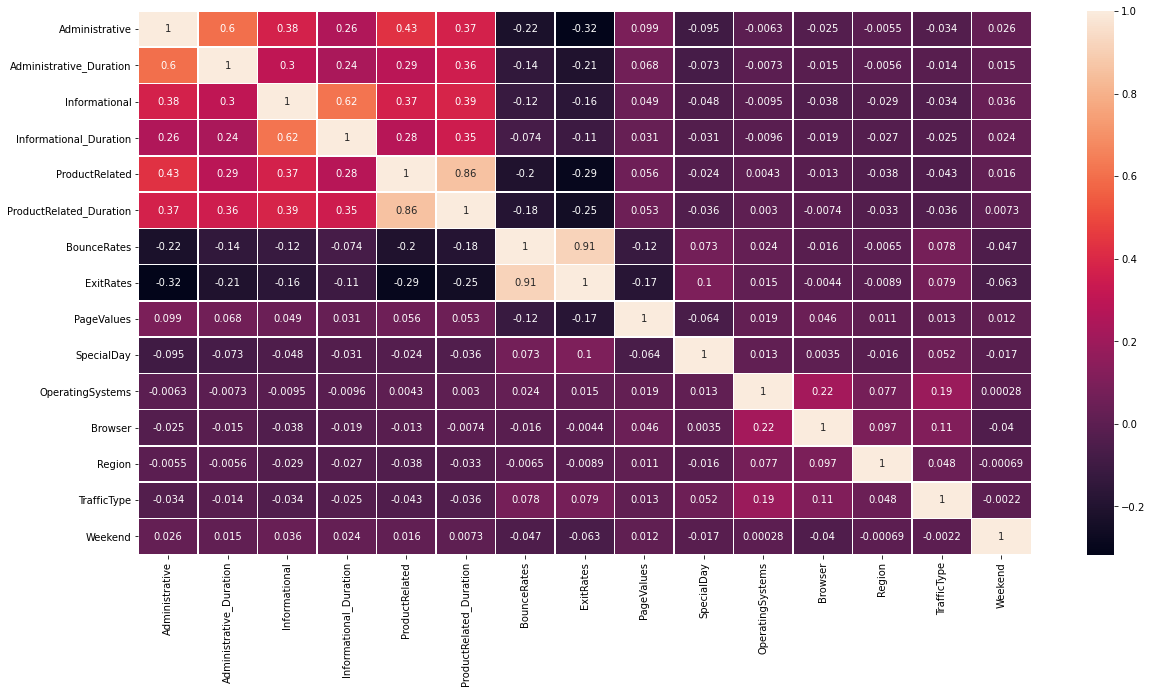

In [5]:
corrMatrix = X.corr()
plt.figure(figsize = (20,10))
sns.heatmap(corrMatrix, annot=True, linewidths=0.5)
plt.show()

In [6]:
X=preprocess.pages_per_sec(X,'Administrative','Administrative_Duration')
X=preprocess.pages_per_sec(X,'Informational','Informational_Duration')
X=preprocess.pages_per_sec(X,'ProductRelated','ProductRelated_Duration')

In [7]:
numerical_columns=['Administrative','Informational',
                             'ProductRelated','BounceRates','ExitRates','PageValues',
                           'SpecialDay']
categorical_columns=['Month','OperatingSystems','Browser','Region','TrafficType','VisitorType','Weekend']

In [8]:
Y.value_counts()

False    10422
True      1908
Name: Revenue, dtype: int64

In [9]:
category_count=[]
for i in categorical_columns:
    category_count.append(X.loc[:,i].value_counts())
category_count

[May     3364
 Nov     2998
 Mar     1907
 Dec     1727
 Oct      549
 Sep      448
 Aug      433
 Jul      432
 June     288
 Feb      184
 Name: Month, dtype: int64,
 2    6601
 1    2585
 3    2555
 4     478
 8      79
 6      19
 7       7
 5       6
 Name: OperatingSystems, dtype: int64,
 2     7961
 1     2462
 4      736
 5      467
 6      174
 10     163
 8      135
 3      105
 13      61
 7       49
 12      10
 11       6
 9        1
 Name: Browser, dtype: int64,
 1    4780
 3    2403
 4    1182
 2    1136
 6     805
 7     761
 9     511
 8     434
 5     318
 Name: Region, dtype: int64,
 2     3913
 1     2451
 3     2052
 4     1069
 13     738
 10     450
 6      444
 8      343
 5      260
 11     247
 20     198
 9       42
 7       40
 15      38
 19      17
 14      13
 18      10
 16       3
 12       1
 17       1
 Name: TrafficType, dtype: int64,
 Returning_Visitor    10551
 New_Visitor           1694
 Other                   85
 Name: VisitorType, dtype: int64,

In [10]:
X=preprocess.rare_categories(X,categorical_columns)
category_count1=[]
for i in categorical_columns:
    category_count1.append(X.loc[:,i].value_counts())
category_count1

[May      3364
 Nov      2998
 Other    2334
 Mar      1907
 Dec      1727
 Name: Month, dtype: int64,
 2    6601
 1    2585
 3    2555
 9     589
 Name: OperatingSystems, dtype: int64,
 2     7961
 1     2462
 14    1907
 Name: Browser, dtype: int64,
 1     4780
 10    2829
 3     2403
 4     1182
 2     1136
 Name: Region, dtype: int64,
 21    3914
 2     3913
 1     2451
 3     2052
 Name: TrafficType, dtype: int64,
 Returning_Visitor    10551
 New_Visitor           1694
 Other                   85
 Name: VisitorType, dtype: int64,
 False    9462
 True     2868
 Name: Weekend, dtype: int64]

In [11]:
xtrain,xtest,ytrain,ytest=preprocess.train_test_split(X,Y)
xtrain=xtrain.reset_index(drop=True)
ytrain=ytrain.reset_index(drop=True)
xtest=xtest.reset_index(drop=True)
ytest=ytest.reset_index(drop=True)

In [12]:
ytrain.value_counts()

False    8338
True     1526
Name: Revenue, dtype: int64

In [13]:
labelencoder = LabelEncoder()
xtrain_plot=xtrain.copy()
for i in categorical_columns:
    xtrain_plot[i] = labelencoder.fit_transform(xtrain_plot[i])

(<Figure size 576x576 with 1 Axes>,
 <AxesSubplot:>,
 [Text(-5.8684688, 3.3277507, '0'), Text(14.944876, -25.374231, '1')])

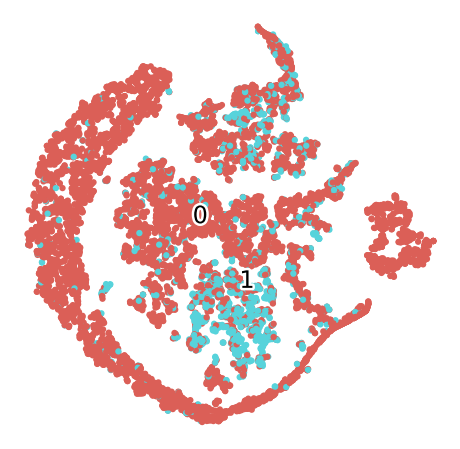

In [14]:
tsne = TSNE(random_state=0).fit_transform(xtrain_plot)
def scatter(x, colors):
    
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))

    
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    
    txts = []

    for i in range(num_classes):

        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

scatter(tsne, ytrain)

In [15]:
xtrain_rbo=xtrain.copy()
rbo=Radial_basis_Oversampling(xtrain_rbo,ytrain,minority_class_label=True,majority_class_label=False,
                                     lamda=0.4,count=6000,step_size=0.1,cat_start_index=7,
                                         categorical_columns=categorical_columns)
new_points_rbo=rbo.points()

100%|██████████| 1526/1526 [01:06<00:00, 22.89it/s]


rbo will generate points after tqdm is completed! (i,e) it is still running after tqdm reaches 100%

In [16]:
xtrain_rbo=xtrain.append(new_points_rbo)
ytrain_rbo=ytrain.append(pd.Series([True]*new_points_rbo.shape[0]))

In [17]:
xtrain_rbo

,Administrative,Informational,ProductRelated,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend
0,18.857143,64.016667,29.398429,0.023134,0.032706,5.613708,0.0,Other,3,2,3,21,Returning_Visitor,False
1,46.333333,0.000000,27.714286,0.000000,0.007692,0.000000,0.0,Mar,3,2,1,2,Returning_Visitor,True
2,35.585648,149.166667,35.066095,0.016970,0.014710,8.216178,0.0,Nov,3,2,3,2,Returning_Visitor,True
3,12.000000,395.000000,28.631944,0.000000,0.014286,0.000000,0.0,Mar,2,2,1,2,New_Visitor,False
4,0.000000,0.000000,29.300000,0.000000,0.050000,0.000000,0.0,Other,1,2,2,1,Returning_Visitor,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5996,0.000000,37.400000,49.847826,0.015385,0.023077,72.520769,0.0,May,9,14,1,2,Other,True
5997,21.722222,8.000000,26.057971,0.108333,0.016667,5.494500,0.0,May,1,14,2,21,Returning_Visitor,True
5998,0.000000,26.000000,69.416459,0.001961,0.023181,2.172431,0.8,May,3,1,3,1,Returning_Visitor,True
5999,0.000000,25.900000,69.416459,0.001961,0.023181,2.172431,0.8,May,1,1,3,1,Returning_Visitor,True


(<Figure size 576x576 with 1 Axes>,
 <AxesSubplot:>,
 [Text(2.38775, 13.596171, '0'), Text(-5.837819, -17.760561, '1')])

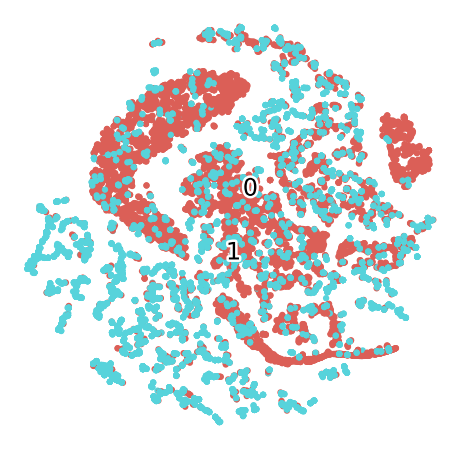

In [18]:
labelencoder1 = LabelEncoder()
xtrain_plot1=xtrain_rbo.copy()
for i in categorical_columns:
    xtrain_plot1[i] = labelencoder1.fit_transform(xtrain_plot1[i])
tsne = TSNE(random_state=0).fit_transform(xtrain_plot1)
scatter(tsne, ytrain_rbo)

In [19]:
xtrain_smote=xtrain.copy()
smote=smote(xtrain_smote,ytrain,True,numerical_columns,categorical_columns,7)
new_points_smote=smote.smote_nc()

100%|██████████| 1526/1526 [00:18<00:00, 80.70it/s]


In [20]:
xtrain_smote=xtrain.append(new_points_smote)
ytrain_smote=ytrain.append(pd.Series([True]*new_points_smote.shape[0]))
for i in categorical_columns:
    xtrain_smote[i]=xtrain_smote[i].astype(str)

(<Figure size 576x576 with 1 Axes>,
 <AxesSubplot:>,
 [Text(-16.284323, 2.32085, '0'), Text(14.588205, -1.6158094, '1')])

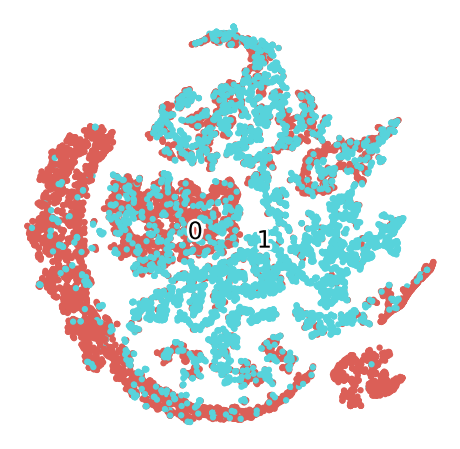

In [21]:
xtrain_smote_plot=xtrain_smote.copy()
labelencoder2 = LabelEncoder()
for i in categorical_columns:
    xtrain_smote_plot[i]=xtrain_smote_plot[i].astype(str)
    xtrain_smote_plot[i] = labelencoder2.fit_transform(xtrain_smote_plot[i])
tsne = TSNE(random_state=0).fit_transform(xtrain_smote_plot)
scatter(tsne, ytrain_smote)

In [22]:
xtrain_copy_1=xtrain_rbo.copy()
xtrain_copy_2=xtrain_smote.copy()

In [23]:
mrmr=mRMR(xtrain_copy_1,ytrain_rbo,7,numerical_columns)
top_features=mrmr.select()
print('Top 7 features selected using Maximum Relevence And Minimum Redundancy')
print(top_features)
new_numerical_columns=[]
new_categorical_columns=[]

for i in top_features:
    if i in numerical_columns:
        new_numerical_columns.append(i)
    else:
        new_categorical_columns.append(i)
print('New numerical columns')
print(new_numerical_columns)
print('New categorical columns')
print(new_categorical_columns)
top_features=new_numerical_columns+new_categorical_columns
cat_start_index=len(new_numerical_columns)

Top 7 features selected using Maximum Relevence And Minimum Redundancy
['PageValues', 'Month', 'VisitorType', 'Weekend', 'BounceRates', 'Browser', 'Informational']
New numerical columns
['PageValues', 'BounceRates', 'Informational']
New categorical columns
['Month', 'VisitorType', 'Weekend', 'Browser']


In [24]:
xtrain_new_rbo=xtrain_rbo.loc[:,top_features]
xtrain_new_rbo_norm=preprocess.log_normalize(xtrain_new_rbo,new_numerical_columns)

xtrain_new_smote=xtrain_smote.loc[:,top_features]
xtrain_new_smote_norm=preprocess.log_normalize(xtrain_new_smote, new_numerical_columns)

xtest_new=xtest.loc[:,top_features]
xtest_new_norm=preprocess.log_normalize(xtest_new, new_numerical_columns)

LOGISTIC REGRESSION

In [25]:
lr_rbo=logisticRegression(xtrain_new_rbo_norm,ytrain_rbo,xtest_new_norm,ytest,maxiteration=50000,tolerance=0.001,learningrate=0.0001,categories=new_categorical_columns)
ypred=lr_rbo.run_model()
accuracy1=accuracy_score(ypred,ytest)
precision1=precision_score(ypred,ytest)
recall1=recall_score(ypred,ytest)
print('Logistic Regression result using radial basis oversampling')
print('accuracy:',accuracy1)
print('precision:',precision1)
print('recall:',recall1)

100%|██████████| 50000/50000 [01:01<00:00, 812.53it/s]

Logistic Regression result using radial basis oversampling
accuracy: 0.8957826439578265
precision: 0.6073298429319371
recall: 0.6843657817109144


In [26]:
lr_smote=logisticRegression(xtrain_new_smote_norm,ytrain_smote,xtest_new_norm,ytest,maxiteration=50000,tolerance=0.001,learningrate=0.0001,categories=new_categorical_columns)
ypred_=lr_smote.run_model()
accuracy2=accuracy_score(ypred_,ytest)
precision2=precision_score(ypred_,ytest)
recall2=recall_score(ypred_,ytest)
print('Logistic Regression result using synthetic minority oversampling')
print('accuracy:',accuracy2)
print('precision:',precision2)
print('recall:',recall2)

100%|██████████| 50000/50000 [00:57<00:00, 869.80it/s]


Logistic Regression result using synthetic minority oversampling
accuracy: 0.8990267639902676
precision: 0.6204188481675392
recall: 0.6950146627565983


NAIVE BAYES CLASSIFIER

In [27]:
xtrainNB_rbo=xtrain_new_rbo_norm.copy()
xtestNB_rbo=xtest_new_norm.copy()

In [28]:
NB_rbo=naive_bayes(xtrainNB_rbo,ytrain_rbo,xtestNB_rbo,ytest,new_numerical_columns,new_categorical_columns,cat_start_index)
ypred_nb_rbo=NB_rbo.run_model()
accuracy3=accuracy_score(ypred_nb_rbo,ytest)
precision3=precision_score(ypred_nb_rbo,ytest)
recall3=recall_score(ypred_nb_rbo,ytest)
print('Naive Bayes Classifier result using radial basis oversampling')
print('accuracy:',accuracy3)
print('precision:',precision3)
print('recall:',recall3)

Naive Bayes Classifier result using radial basis oversampling
accuracy: 0.6581508515815085
precision: 0.8952879581151832
recall: 0.2986899563318777


In [29]:
xtrainNB_smote=xtrain_new_smote_norm.copy()
xtestNB_smote=xtest_new_norm.copy()

In [30]:
NB_smote=naive_bayes(xtrainNB_smote,ytrain_smote,xtestNB_smote,ytest,new_numerical_columns,new_categorical_columns,cat_start_index)
ypred_nb_smote=NB_smote.run_model()
accuracy3=accuracy_score(ypred_nb_smote,ytest)
precision3=precision_score(ypred_nb_smote,ytest)
recall3=recall_score(ypred_nb_smote,ytest)
print('Naive Bayes Classifier result using synthetic minority oversampling')
print('accuracy:',accuracy3)
print('precision:',precision3)
print('recall:',recall3)

Naive Bayes Classifier result using synthetic minority oversampling
accuracy: 0.6800486618004866
precision: 0.9031413612565445
recall: 0.31449407474931634


SVM

In [31]:
xtrain_svm_rbo=xtrain_new_rbo_norm.copy()
xtest_svm_rbo=xtest_new_norm.copy()

In [ ]:
svm_rbo=SVM(5,0.0001,xtrain_svm_rbo,ytrain_rbo,xtest_svm_rbo,0.0001,new_categorical_columns)
ypred_svm_rbo=svm_rbo.fit()
accuracy4=accuracy_score(ypred_svm_rbo,ytest)
precision4=precision_score(ypred_svm_rbo,ytest)
recall4=recall_score(ypred_svm_rbo,ytest)
print('SVM result using radial basis oversampling')
print('accuracy:',accuracy4)
print('precision:',precision4)
print('recall:',recall4)

 83%|████████▎ | 83/100 [00:04<00:00, 19.28it/s]

In [ ]:
xtrain_svm_smote=xtrain_new_smote_norm.copy()
xtest_svm_smote=xtest_new_norm.copy()

In [ ]:
svm_smote=SVM(10,0.001,xtrain_svm_rbo,ytrain_rbo,xtest_svm_rbo,0.0001,new_categorical_columns)
ypred_svm_smote=svm_smote.fit()
accuracy4=accuracy_score(ypred_svm_smote,ytest)
precision4=precision_score(ypred_svm_smote,ytest)
recall4=recall_score(ypred_svm_smote,ytest)
print('SVM result using synthetic minority oversampling')
print('accuracy:',accuracy4)
print('precision:',precision4)
print('recall:',recall4)

# Random Forest

In [20]:
import pandas as pd

In [21]:
df_rf=pd.read_csv('online_shoppers_intention.csv')

In [22]:
def replace_bool_value(data):
    for val in data.columns:
        if data[val].dtype==bool:
            data.loc[data[val]==True,val]=1
            data.loc[data[val]==False,val]=0
            data[val] = data[val].astype("int64")
    return data

In [23]:
##replce bool
df_rf = replace_bool_value(df_rf)

In [24]:
##one hot encode
cols_encodes=['Month','VisitorType']
df_rf = pd.get_dummies(df_rf, columns=cols_encodes,dtype='int64')

In [25]:
X_rf = df_rf.loc[:, df_rf.columns!='Revenue']
y_rf = df_rf.loc[:, df_rf.columns=='Revenue']

In [26]:
##split train and test sets
from sklearn.model_selection import train_test_split
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y_rf, test_size=0.3, random_state=0)
train = X_train_rf
test = X_test_rf
train_labels = y_train_rf
test_labels = y_test_rf

In [27]:
import numpy as np
import pandas as pd

# Set random seed to ensure reproducible runs
RSEED = 50
from sklearn.ensemble import RandomForestClassifier

# Create the model with 100 trees
model = RandomForestClassifier(n_estimators=100, 
                               random_state=RSEED, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 1)

# Fit on training data

In [28]:
# Fit on training data
model.fit(train, train_labels)

<ipython-input-28-d40fb2621b15>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train, train_labels)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished


RandomForestClassifier(max_features='sqrt', n_jobs=-1, random_state=50,
                       verbose=1)

In [29]:
##describe trees
n_nodes = []
max_depths = []

for ind_tree in model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of nodes 1558
Average maximum depth 25


In [30]:
train_rf_predictions = model.predict(train)
train_rf_probs = model.predict_proba(train)[:, 1]

rf_predictions = model.predict(test)
rf_probs = model.predict_proba(test)[:, 1]

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [31]:
from sklearn.metrics import recall_score, precision_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
%matplotlib inline
def evaluate_model(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['precision'] = precision_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(test_labels, predictions)
    results['precision'] = precision_score(test_labels, predictions)
    results['roc'] = roc_auc_score(test_labels, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(train_labels, train_predictions)
    train_results['precision'] = precision_score(train_labels, train_predictions)
    train_results['roc'] = roc_auc_score(train_labels, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(test_labels, [1 for _ in range(len(test_labels))])
    model_fpr, model_tpr, _ = roc_curve(test_labels, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');

Recall Baseline: 1.0 Test: 0.55 Train: 1.0
Precision Baseline: 0.17 Test: 0.75 Train: 1.0
Roc Baseline: 0.5 Test: 0.92 Train: 1.0


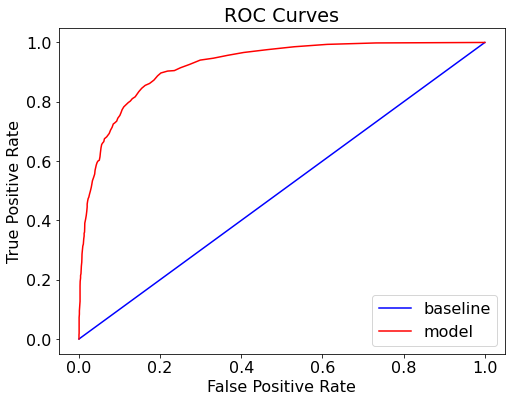

In [32]:
evaluate_model(rf_predictions, rf_probs, train_rf_predictions, train_rf_probs)

In [33]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

Confusion matrix, without normalization
[[2966  111]
 [ 283  339]]


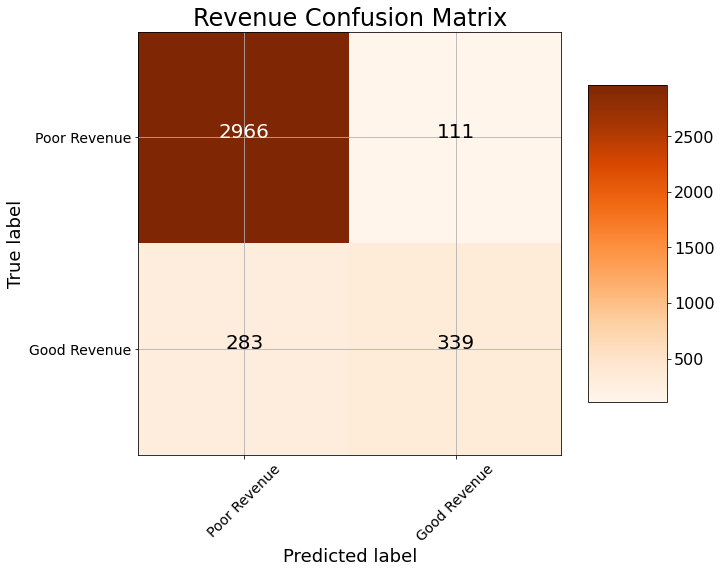

In [34]:
cm = confusion_matrix(test_labels, rf_predictions)
plot_confusion_matrix(cm, classes = ['Poor Revenue', 'Good Revenue'],
                      title = 'Revenue Confusion Matrix')

In [35]:
##show features according to their importances
features = list(train.columns)
fi_model = pd.DataFrame({'feature': features,
                   'importance': model.feature_importances_}).\
                    sort_values('importance', ascending = False)
fi_model.head(10)

,feature,importance
8,PageValues,0.357234
7,ExitRates,0.091093
5,ProductRelated_Duration,0.086415
4,ProductRelated,0.072482
1,Administrative_Duration,0.057205
6,BounceRates,0.055414
0,Administrative,0.044969
13,TrafficType,0.031962
12,Region,0.031069
3,Informational_Duration,0.027105


In [36]:
##search for the optimal parameter of trees
from sklearn.model_selection import RandomizedSearchCV

# Hyperparameter grid
param_grid = {
    'n_estimators': np.linspace(10, 200).astype(int),
    'max_depth': [None] + list(np.linspace(3, 20).astype(int)),
    'max_features': ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1)),
    'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False]
}

# Estimator for use in random search
estimator = RandomForestClassifier(random_state = RSEED)

# Create the random search model
rs = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
                        scoring = 'roc_auc', cv = 3, 
                        n_iter = 10, verbose = 1, random_state=RSEED)

# Fit 
rs.fit(train, train_labels)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_search.py:880: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=50),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 3, 3, 3, 4, 4, 4, 5,
                                                      5, 5, 6, 6, 6, 7, 7, 7, 8,
                                                      8, 8, 9, 9, 9, 10, 10, 10,
                                                      11, 11, 12, 12, 12, ...],
                                        'max_features': ['auto', 'sqrt', None,
                                                         0.5, 0.6, 0.7,
                                                         0.7999999999999999,
                                                         0.8999999999999999],
                                        'max_leaf_nodes': [None, 10, 10, 10, 10,
                                                           10, 10, 10, 10, 10,
                                     

In [37]:
rs.best_params_

{'n_estimators': 184,
 'min_samples_split': 2,
 'max_leaf_nodes': 40,
 'max_features': 0.7999999999999999,
 'max_depth': 14,
 'bootstrap': False}

In [38]:
best_model = rs.best_estimator_

In [39]:
train_rf_predictions = best_model.predict(train)
train_rf_probs = best_model.predict_proba(train)[:, 1]

rf_predictions = best_model.predict(test)
rf_probs = best_model.predict_proba(test)[:, 1]

In [40]:
n_nodes = []
max_depths = []

for ind_tree in best_model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of nodes 79
Average maximum depth 9


Recall Baseline: 1.0 Test: 0.59 Train: 0.67
Precision Baseline: 0.17 Test: 0.74 Train: 0.81
Roc Baseline: 0.5 Test: 0.92 Train: 0.94


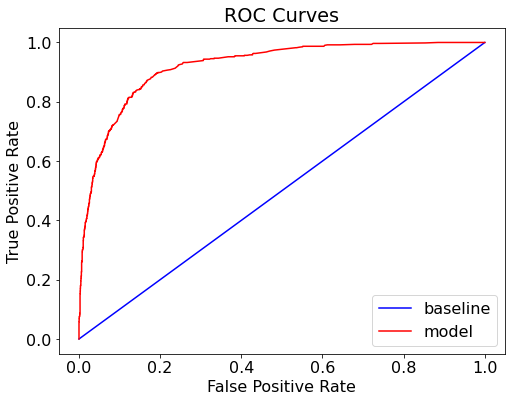

In [41]:
evaluate_model(rf_predictions, rf_probs, train_rf_predictions, train_rf_probs)

In [42]:
from sklearn.tree import export_graphviz
from subprocess import call
from IPython.display import Image

In [43]:
estimator = best_model.estimators_[1]

# Export a tree from the forest
export_graphviz(estimator, 'tree_from_optimized_forest.dot', rounded = True, 
                feature_names=train.columns, max_depth = 8, 
                class_names = ['poverty', 'no poverty'], filled = True)

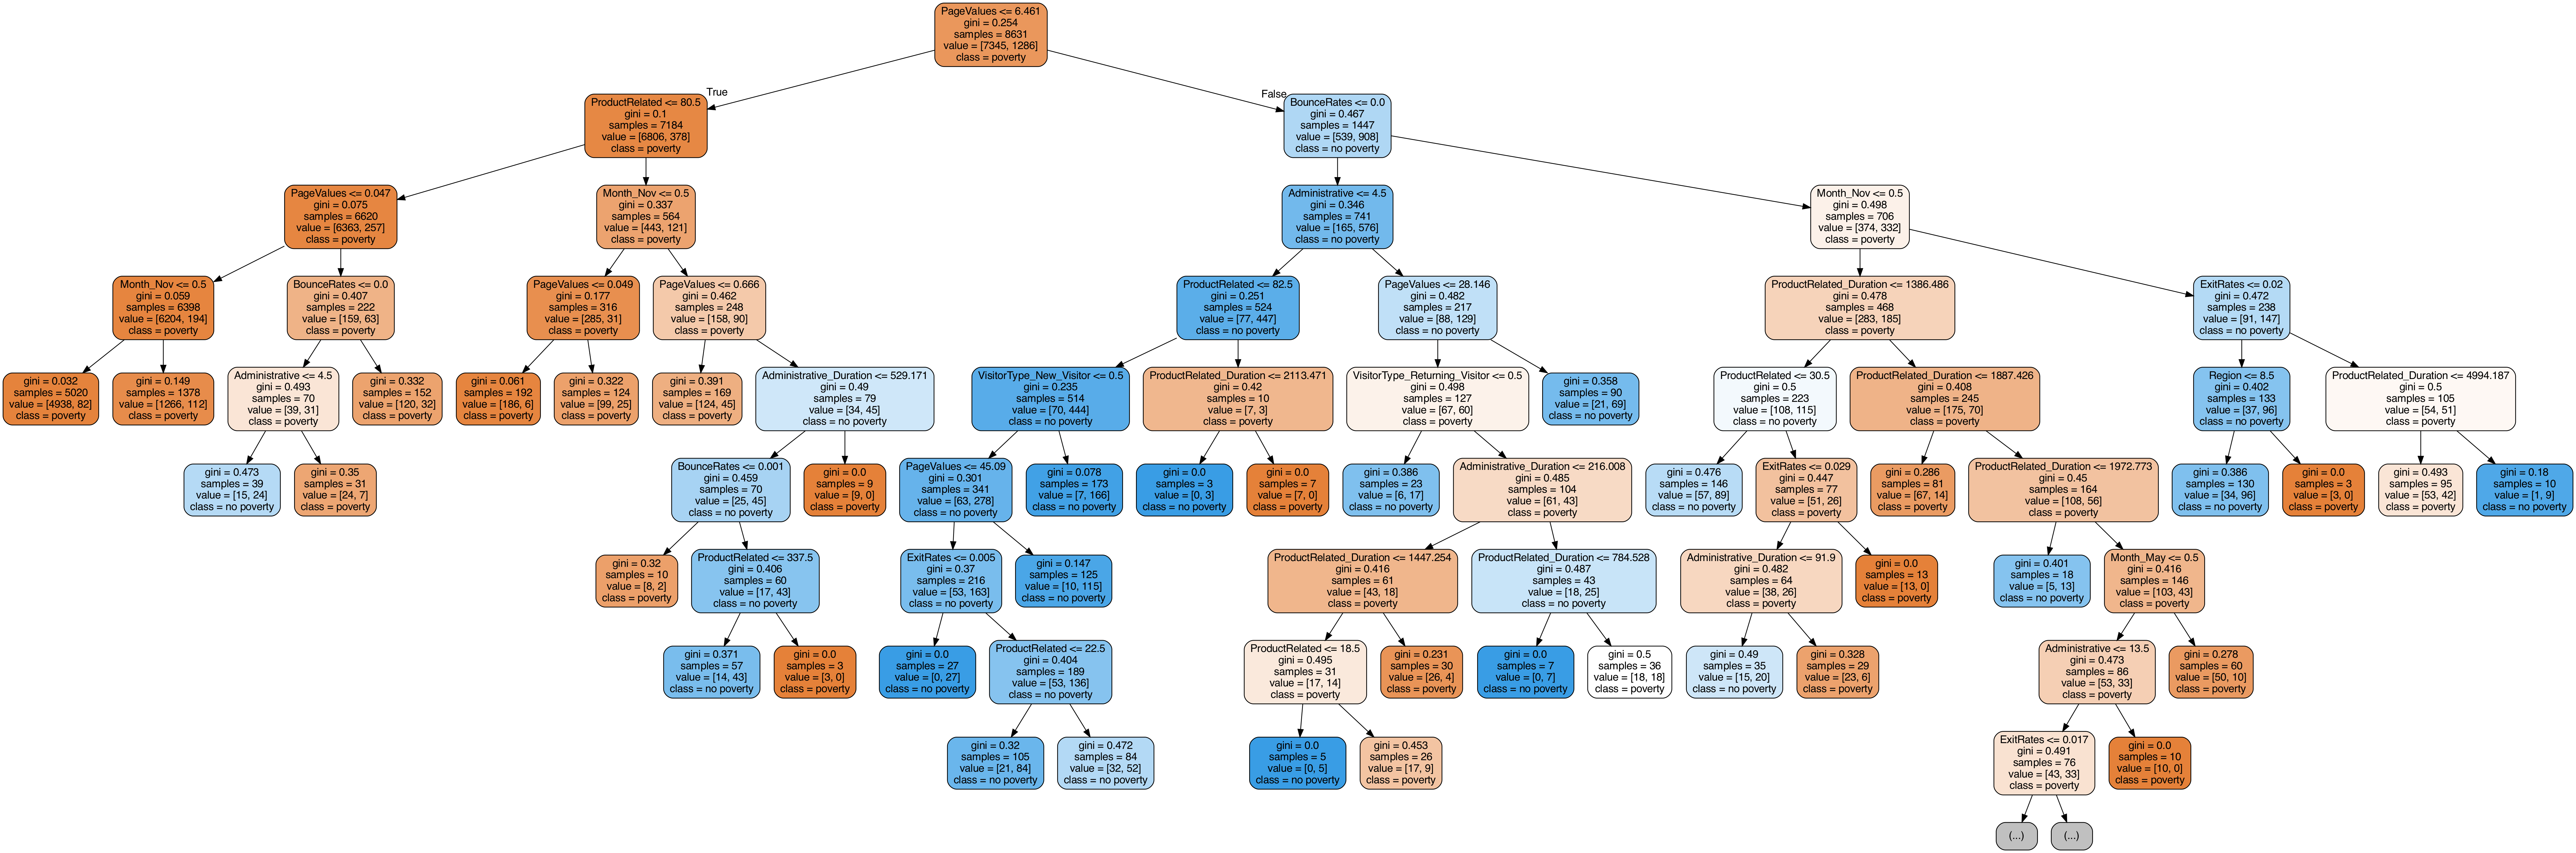

In [44]:
call(['dot', '-Tpng', 'tree_from_optimized_forest.dot', '-o', 'tree_from_optimized_forest.png', '-Gdpi=200'])
Image('tree_from_optimized_forest.png')
##Should install GraphViz，because the file is the 
#format of.dot，